In [100]:
import pandas as pd
import matplotlib
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time

#### Leading the cleaned dataset from previous step

In [2]:
# Load CSV files
df = pd.read_csv('D:/Courses/INSY 695/Project Repository/E-commerce_Promotion_Analysis/Datasets/feature_library.csv')

#'D:/Courses/INSY 695/Project Repository/E-commerce_Promotion_Analysis/Datasets/cleaned_trained_data.csv'

In [3]:
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,...,Occupation_Teacher,Occupation_Writer,Credit_Mix_Good,Credit_Mix_Standard,Payment_of_Min_Amount_Yes,Payment_Behaviour_High_spent_Medium_value_payments,Payment_Behaviour_High_spent_Small_value_payments,Payment_Behaviour_Low_spent_Large_value_payments,Payment_Behaviour_Low_spent_Medium_value_payments,Payment_Behaviour_Low_spent_Small_value_payments
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23.0,821-00-0265,19114,1824.843333,3,4,...,0,0,1,0,0,0,1,0,0,0
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23.0,821-00-0265,19114,3093.745000,3,4,...,0,0,1,0,0,0,0,1,0,0
2,0x1604,CUS_0xd40,March,Aaron Maashoh,23.0,821-00-0265,19114,3093.745000,3,4,...,0,0,1,0,0,0,0,0,1,0
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23.0,821-00-0265,19114,3093.745000,3,4,...,0,0,1,0,0,0,0,0,0,1
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23.0,821-00-0265,19114,1824.843333,3,4,...,0,0,1,0,0,1,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 62 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   ID                                                  100000 non-null  object 
 1   Customer_ID                                         100000 non-null  object 
 2   Month                                               100000 non-null  object 
 3   Name                                                100000 non-null  object 
 4   Age                                                 100000 non-null  float64
 5   SSN                                                 100000 non-null  object 
 6   Annual_Income                                       100000 non-null  int64  
 7   Monthly_Inhand_Salary                               100000 non-null  float64
 8   Num_Bank_Accounts                                   100000 non-nu

#### Extracting numerical, ordinal and one-hot encoding variables to apply relevant preprocessing

In [5]:
# Define column groups based on dataset
num_cols = [
    "Age", "Annual_Income", "Monthly_Inhand_Salary", "Num_Bank_Accounts",
    "Num_Credit_Card", "Interest_Rate", "Num_of_Loan", "Delay_from_due_date",
    "Num_of_Delayed_Payment", "Changed_Credit_Limit", "Num_Credit_Inquiries",
    "Outstanding_Debt", "Credit_Utilization_Ratio", "Credit_History_Age",
    "Total_EMI_per_month", "Amount_invested_monthly", "Monthly_Balance",
    "income_zscore", "Monthly_Inhand_Salary_log", "Delay_Zscore",
    "Month_num", "Month_sin", "Month_cos"
]


#Encoded one-hot columns
one_hot_cols = [
    "Auto Loan", "Credit-Builder Loan", "Personal Loan", "Home Equity Loan",
    "Not Specified", "No Loan", "Mortgage Loan", "Student Loan", "Debt Consolidation Loan",
    "Payday Loan", 

    "Occupation_Architect", "Occupation_Developer", "Occupation_Doctor",
    "Occupation_Engineer", "Occupation_Entrepreneur", "Occupation_Journalist",
    "Occupation_Lawyer", "Occupation_Manager", "Occupation_Mechanic",
    "Occupation_Media_Manager", "Occupation_Musician", "Occupation_Scientist",
    "Occupation_Teacher", "Occupation_Writer",

    "Credit_Mix_Good", "Credit_Mix_Standard",
    "Payment_of_Min_Amount_Yes",

    "Payment_Behaviour_High_spent_Medium_value_payments",
    "Payment_Behaviour_High_spent_Small_value_payments",
    "Payment_Behaviour_Low_spent_Large_value_payments",
    "Payment_Behaviour_Low_spent_Medium_value_payments",
    "Payment_Behaviour_Low_spent_Small_value_payments"
]


target_col = ["Credit_Score"]

In [6]:
# Apply Label Encoding to each column
for col in target_col:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

#### Scaling the numerical columns

In [7]:
# Initialize StandardScaler
scaler = StandardScaler()

In [8]:
# Split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=target_col), df[target_col], test_size=0.2, random_state=42, stratify=df[['Customer_ID']]
)

In [9]:
# Fit transformer on training data & apply transformation
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [10]:
# Ensure only numerical features are included
X_train_final = X_train.select_dtypes(exclude=['object'])
X_test_final = X_test.select_dtypes(exclude=['object'])


#### Trying 3 different feature selection methods: RFE, RF Feature Importances, LassoCV

In [11]:
# Define model
model1 = XGBClassifier(random_state=42)

In [12]:
# Apply Recursive Feature Elimination (RFE)
rfe = RFE(estimator = model1, n_features_to_select=10)
X_selected = rfe.fit_transform(X_train_final, y_train)

In [13]:
# Create DataFrame of feature rankings
feature_ranking = pd.DataFrame({'Feature': X_train_final.columns, 'Ranking': rfe.ranking_})

# Sort by ranking
feature_ranking = feature_ranking.sort_values(by="Ranking")

# Display rankings
print(feature_ranking)

                                              Feature  Ranking
54   Payment_Behaviour_Low_spent_Small_value_payments        1
47                                    Credit_Mix_Good        1
11                                   Outstanding_Debt        1
48                                Credit_Mix_Standard        1
7                                 Delay_from_due_date        1
9                                Changed_Credit_Limit        1
4                                     Num_Credit_Card        1
49                          Payment_of_Min_Amount_Yes        1
5                                       Interest_Rate        1
20                                          Month_num        1
3                                   Num_Bank_Accounts        2
1                                       Annual_Income        3
10                               Num_Credit_Inquiries        4
14                                Total_EMI_per_month        5
32                                        Payday Loan  

In [14]:
# Define model
model2 = RandomForestClassifier(random_state=42)

In [15]:
# Train a random forest model
model2.fit(X_train_final, y_train)

c:\Users\ZAID\anaconda3\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

In [16]:
# Get feature importance scores
feature_importances = model2.feature_importances_

# Rank features
feature_ranking = pd.Series(feature_importances, index=X_train_final.columns).sort_values(ascending=False)

In [17]:
# Display top features
print("Feature Importances:")
print(feature_ranking)

Feature Importances:
Outstanding_Debt                                      0.092641
Interest_Rate                                         0.069183
Credit_Mix_Good                                       0.045403
Delay_from_due_date                                   0.042796
Delay_Zscore                                          0.040671
Credit_Mix_Standard                                   0.038461
Changed_Credit_Limit                                  0.037772
Num_Credit_Card                                       0.036837
Monthly_Balance                                       0.034398
Credit_Utilization_Ratio                              0.033477
Annual_Income                                         0.033386
Num_Credit_Inquiries                                  0.033165
Credit_History_Age                                    0.033061
Amount_invested_monthly                               0.032803
Num_of_Delayed_Payment                                0.031439
Total_EMI_per_month               

In [18]:
# Perform Lasso Feature Selection with Cross-Validation
lasso = LassoCV(cv=5, random_state=42)  # 5-fold cross-validation
lasso.fit(X_train_final, y_train)

c:\Users\ZAID\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LassoCV(cv=5, random_state=42)

In [19]:
# Get the coefficients of the selected features
lasso_coeffs = pd.Series(lasso.coef_, index=X_train_final.columns)

# Filter out features with non-zero coefficients (important features)
selected_features = lasso_coeffs[lasso_coeffs != 0].sort_values(ascending=False)

In [20]:
# Display selected features
print(f"Selected Features: {selected_features}")

Selected Features: Changed_Credit_Limit                                  0.067867
Payment_Behaviour_Low_spent_Small_value_payments      0.043520
Num_Credit_Card                                       0.037084
Monthly_Balance                                       0.034600
Payment_Behaviour_Low_spent_Medium_value_payments     0.028716
Occupation_Mechanic                                   0.028431
Month_cos                                             0.026582
Occupation_Writer                                     0.026137
Credit_Mix_Standard                                   0.023876
Payment_Behaviour_Low_spent_Large_value_payments      0.023795
Monthly_Inhand_Salary_log                             0.021714
Payment_Behaviour_High_spent_Small_value_payments     0.018970
Num_of_Loan                                           0.017895
Occupation_Media_Manager                              0.012322
Month_sin                                             0.007704
Month_num                           

In [21]:
# Select features with non-zero coefficients and sort by absolute importance
top_lasso_features = lasso_coeffs.abs().sort_values(ascending=False).head(10)

# Sort and get top 10 important features from Tree-based model
top_tree_features = feature_ranking.sort_values(ascending=False).head(10)

# Get top 10 features from Recursive Feature Elimination (RFE)
top_rfe_features = X_train_final.columns[rfe.support_]
top_rfe_features = top_rfe_features[:10]

In [22]:
# Get feature names from both methods
lasso_top_names = top_lasso_features.index.tolist()
tree_top_names = top_tree_features.index.tolist()
rfe_top_names = top_rfe_features.tolist()

In [23]:
# Find common features selected by Lasso, Tree-based Model, and RFE
common_features_all = list(set(lasso_top_names) & set(tree_top_names) & set(rfe_top_names))

In [24]:
# Find features common to any two methods
common_features_lasso_tree = list(set(lasso_top_names) & set(tree_top_names))
common_features_lasso_rfe = list(set(lasso_top_names) & set(rfe_top_names))
common_features_tree_rfe = list(set(tree_top_names) & set(rfe_top_names))

In [25]:
# Print Results
print(f"Common Features Across All Three Methods: {common_features_all}")
print(f"Common Features (Lasso & Tree-based): {common_features_lasso_tree}")
print(f"Common Features (Lasso & RFE): {common_features_lasso_rfe}")
print(f"Common Features (Tree-based & RFE): {common_features_tree_rfe}")

Common Features Across All Three Methods: ['Changed_Credit_Limit', 'Interest_Rate', 'Num_Credit_Card', 'Credit_Mix_Good']
Common Features (Lasso & Tree-based): ['Changed_Credit_Limit', 'Interest_Rate', 'Num_Credit_Card', 'Credit_Mix_Good', 'Monthly_Balance']
Common Features (Lasso & RFE): ['Changed_Credit_Limit', 'Interest_Rate', 'Num_Credit_Card', 'Payment_Behaviour_Low_spent_Small_value_payments', 'Payment_of_Min_Amount_Yes', 'Credit_Mix_Good']
Common Features (Tree-based & RFE): ['Changed_Credit_Limit', 'Interest_Rate', 'Num_Credit_Card', 'Delay_from_due_date', 'Outstanding_Debt', 'Credit_Mix_Good', 'Credit_Mix_Standard']


#### Lets try with common features with RFE and Random Forest since Lasso doen't have many common features, probably due to linear assumption of model

In [26]:
# Select the final set of features (either common ones or a union of top features)
final_selected_features = common_features_tree_rfe

In [27]:
# Create a new dataset with only the selected features
X_train_selected = X_train_final[final_selected_features]
X_test_selected = X_test_final[final_selected_features]

In [28]:
y_train = y_train.values.flatten()
y_test = y_test.values.flatten()

#### Testing a few base models with  different strengths using cross-validation to see which model performs the best

In [37]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42), 
    "LightGBM": LGBMClassifier(random_state=42)
}

c:\Users\ZAID\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 423
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] Start training from score -1.725621
[LightGBM] [Info] Start training from score -1.237357
[LightGBM] [Info] Start training from score -0.631511


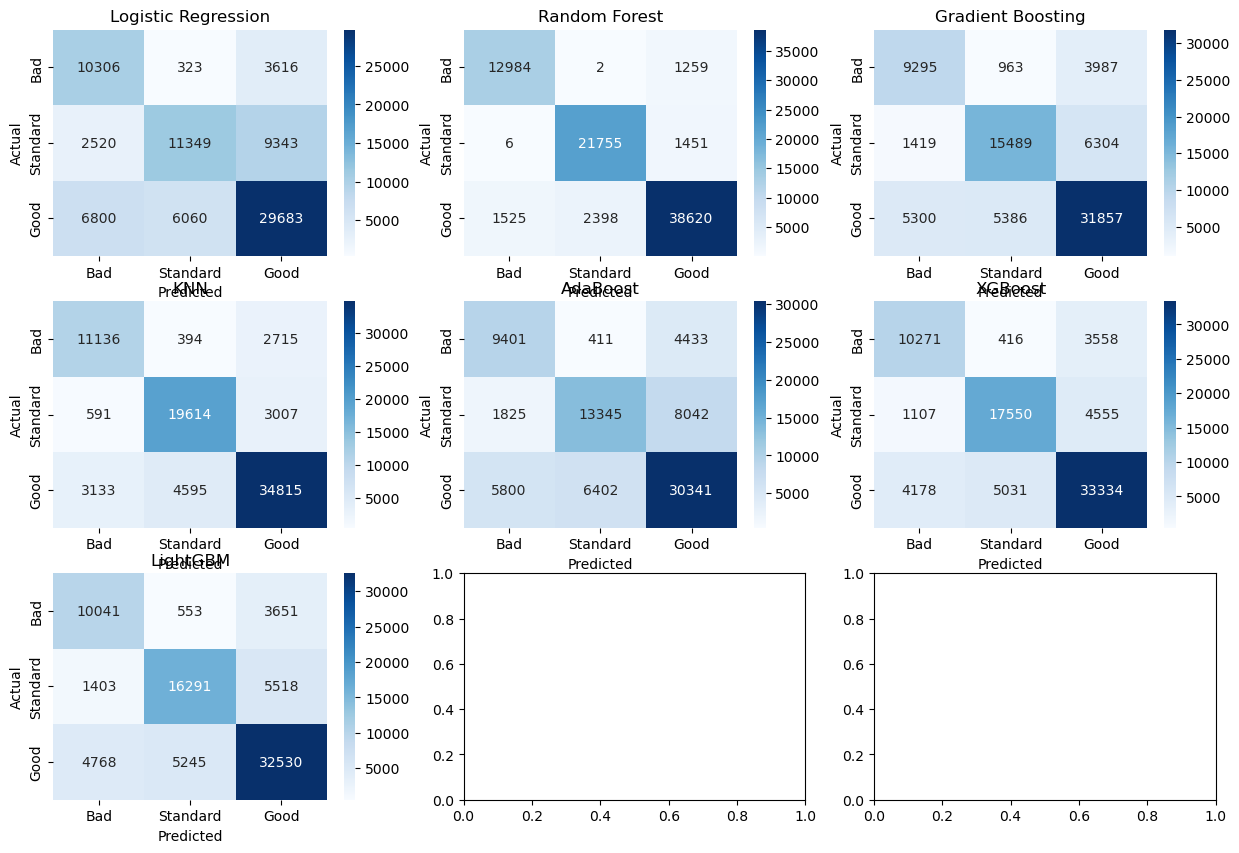

In [39]:
# Set up figure size for multiple subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten() 
# Define class labels 
class_labels = ["Bad", "Standard", "Good"]

# Loop through each model and generate confusion matrix
for i, (name, model) in enumerate(models.items()):
    # Train model
    model.fit(X_train_selected, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_train_selected)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_train, y_pred)

    # Plot confusion matrix as heatmap
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels, ax=axes[i])
    axes[i].set_title(f"{name}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

#### As you can see, for a base model, Random Forest has the least amount of false positives for Good category. Meaning it has the potential to be our choosen model

In [40]:
# Define Stratified K-Fold (Ensures balanced class distribution across folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [41]:
# Dictionary to store cross-validation results
cv_results = {}

In [42]:
# Loop through models and evaluate using cross-validation
for name, model in models.items():
    start_time = time.time()
    
    # Perform 5-fold cross-validation
    scores = cross_val_score(model, X_train_selected, y_train, cv=cv, scoring='accuracy')
    
    # Store mean accuracy and standard deviation
    cv_results[name] = {
        "Mean Accuracy": np.mean(scores),
        "Std Dev": np.std(scores)
    }
    
    # Print results
    print(f"{name}: Mean Accuracy = {np.mean(scores):.4f} ± {np.std(scores):.4f} (Time: {time.time() - start_time:.2f}s)")

Logistic Regression: Mean Accuracy = 0.6416 ± 0.0020 (Time: 0.74s)
Random Forest: Mean Accuracy = 0.7663 ± 0.0027 (Time: 22.45s)
Gradient Boosting: Mean Accuracy = 0.7046 ± 0.0036 (Time: 46.71s)
KNN: Mean Accuracy = 0.7358 ± 0.0038 (Time: 2.31s)


c:\Users\ZAID\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\ZAID\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\ZAID\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\ZAID\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\ZAID\an

AdaBoost: Mean Accuracy = 0.6653 ± 0.0033 (Time: 4.84s)
XGBoost: Mean Accuracy = 0.7355 ± 0.0038 (Time: 1.99s)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 64000, number of used features: 7
[LightGBM] [Info] Start training from score -1.725621
[LightGBM] [Info] Start training from score -1.237336
[LightGBM] [Info] Start training from score -0.631523
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 64000, number of used features: 7
[LightGBM] [Info] Start t

In [43]:
# Convert results to a DataFrame
cv_results_df = pd.DataFrame(cv_results).T
# Sort by Mean Accuracy
cv_results_df = cv_results_df.sort_values(by='Mean Accuracy', ascending=False)

In [44]:
# Display results
print("\nCross-Validation Results:")
print(cv_results_df)


Cross-Validation Results:
                     Mean Accuracy   Std Dev
Random Forest             0.766325  0.002656
KNN                       0.735763  0.003815
XGBoost                   0.735513  0.003803
LightGBM                  0.721750  0.004662
Gradient Boosting         0.704600  0.003607
AdaBoost                  0.665288  0.003315
Logistic Regression       0.641575  0.001980


#### Even with cross validation, we are getting the best performance out of Random Forrest. Let's move ahead with it towards hyperparameter tuning

In [36]:
# Define hyperparameter grid
param_grid = {
    "n_estimators": [100, 200],  # Number of trees
    "max_depth": [10, 20],  # Depth of trees
    "min_samples_split": [2, 5,],  # Minimum samples to split
    "min_samples_leaf": [1, 2, 4]    # Minimum samples per leaf
}

In [37]:
# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

In [38]:

# GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           scoring='accuracy', cv=5, verbose=2)

In [39]:
# Fit GridSearchCV
grid_search.fit(X_train_selected, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.2s
[CV] END max_depth=10, min_sa

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 20], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='accuracy', verbose=2)

In [40]:
# Print best parameters
print(f"Best Hyperparameters: {grid_search.best_params_}")

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [41]:
# Get best model from GridSearch
best_rf = grid_search.best_estimator_

In [42]:
# Evaluate on test set
y_pred = best_rf.predict(X_test_selected)

In [43]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Optimized Random Forest Accuracy: {accuracy:.4f}")

Optimized Random Forest Accuracy: 0.7864


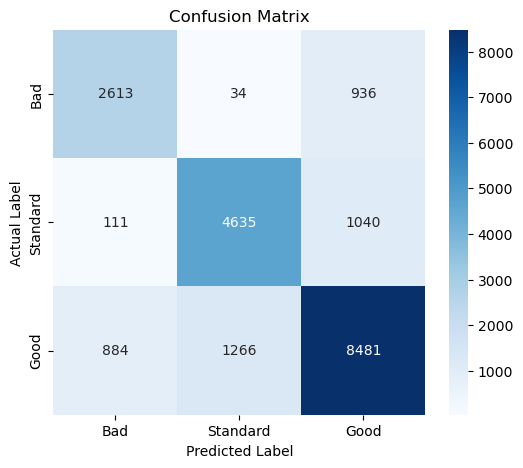

In [44]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

In [45]:
# Get feature importance values
feature_importances = best_rf.feature_importances_

# Get feature names (assuming X_train_selected was used for training)
feature_names = X_train_selected.columns

In [46]:
# Create DataFrame
feat_imp_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})

# Sort by importance
feat_imp_df = feat_imp_df.sort_values(by="Importance", ascending=False)

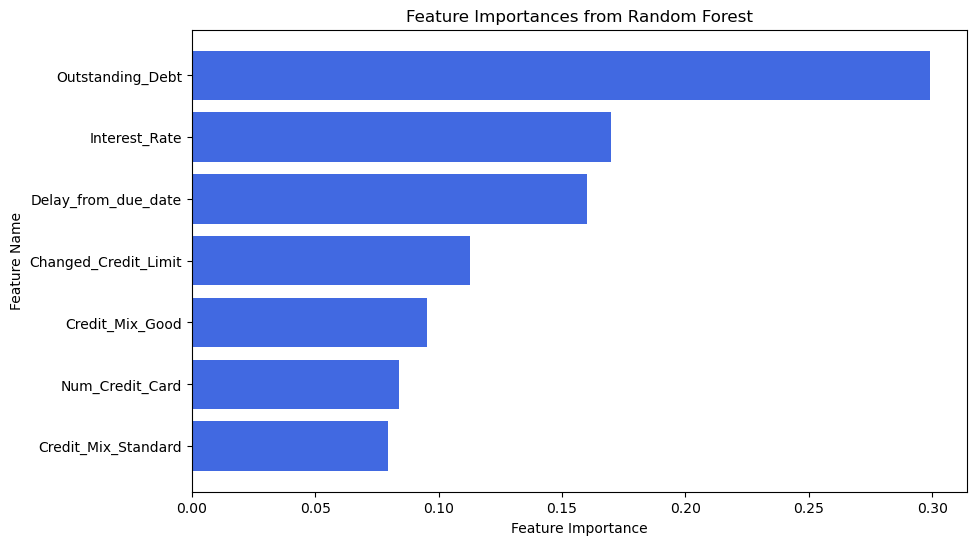

In [47]:
# Plot feature importances
plt.figure(figsize=(10,6))
plt.barh(feat_imp_df["Feature"], feat_imp_df["Importance"], color="royalblue")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importances from Random Forest")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

#### Now, let's Test xGBoost and LightGBM with hyperparameters tuning to see if they performs better than Random Forest

In [45]:
# Define the hyperparameter grid
xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [46]:
# Initialize the XGBoost model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False)

In [47]:
# Perform Grid Search with Cross-Validation
xgb_grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)

In [48]:
# Fit GridSearchCV
xgb_grid_search.fit(X_train_selected, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\ZAID\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [17:54:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=2)

In [50]:
# Get the best parameters
print("Best XGBoost Parameters:", xgb_grid_search.best_params_)

Best XGBoost Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.8}


In [87]:
# Best model
best_xgb = xgb_grid_search.best_estimator_

In [88]:
# Evaluate on test set
y_pred = best_xgb.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)

In [89]:
print(f"Optimized XGBoost Accuracy: {accuracy:.4f}")

Optimized XGBoost Accuracy: 0.7408


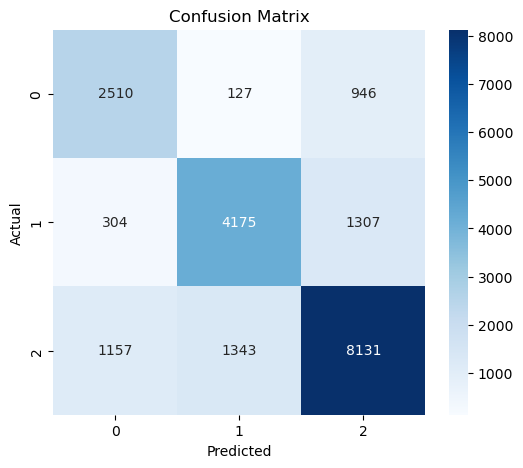

In [61]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=xgb_grid_search.classes_, yticklabels=xgb_grid_search.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [62]:
# Get feature importance from the trained Gradient Boosting model
feature_importance = best_xgb.feature_importances_

In [ ]:
# Convert to DataFrame for better readability
feat_importance_df = pd.DataFrame({"Feature": X_train_selected.columns, "Importance": feature_importance})
feat_importance_df = feat_importance_df.sort_values(by="Importance", ascending=False)

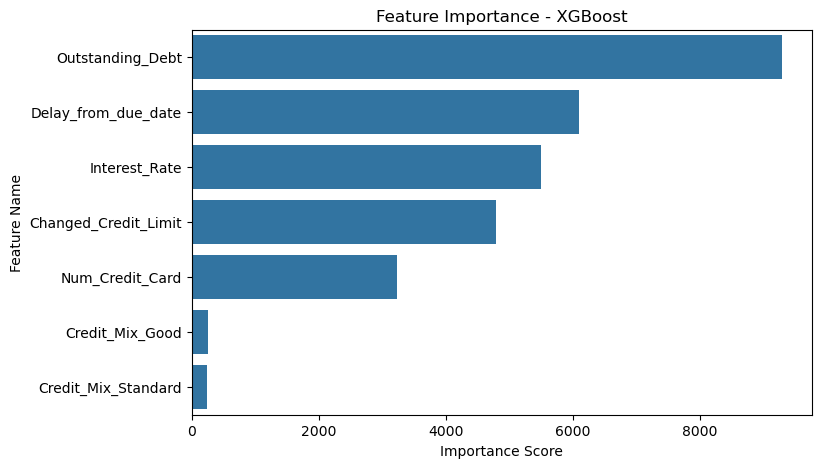

In [82]:
# Plot the top 10 features
plt.figure(figsize=(8, 5))
sns.barplot(x="Importance", y="Feature", data=feat_importance_df[:10])  # Top 10 important features
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.show()

In [65]:
# Define the hyperparameter grid
lgbm_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [-1, 10],
    'num_leaves': [31, 50],
    'subsample': [0.8, 1.0]
}

In [71]:

# Initialize the LightGBM model
lgbm_model = LGBMClassifier(random_state=42)

In [72]:
# Perform Grid Search with Cross-Validation
lgbm_grid_search = GridSearchCV(
    estimator=lgbm_model,
    param_grid=lgbm_param_grid,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)

In [73]:
# Fit GridSearchCV
lgbm_grid_search.fit(X_train_selected, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 423
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] Start training from score -1.725621
[LightGBM] [Info] Start training from score -1.237357
[LightGBM] [Info] Start training from score -0.631511


GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [-1, 10],
                         'n_estimators': [100, 200], 'num_leaves': [31, 50],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=2)

In [90]:

# Get the best parameters
print("Best LightGBM Parameters:", lgbm_grid_search.best_params_)

Best LightGBM Parameters: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 50, 'subsample': 0.8}


In [91]:
# Best model
best_lgbm = lgbm_grid_search.best_estimator_

In [95]:
# Evaluate on test set
y_pred = best_lgbm.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)

In [97]:
print(f"Optimized LightGBM Accuracy: {accuracy:.4f}")

Optimized LightGBM Accuracy: 0.7570


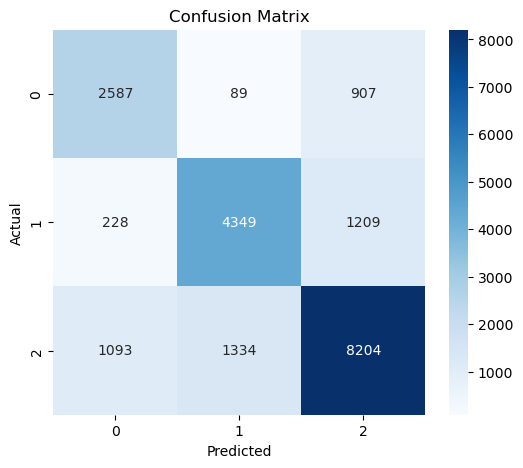

In [98]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=lgbm_grid_search.classes_, yticklabels=lgbm_grid_search.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [79]:
# Get feature importance from the trained Gradient Boosting model
feature_importance = best_lgbm.feature_importances_

In [80]:
# Convert to DataFrame for better readability
feat_importance_df = pd.DataFrame({"Feature": X_train_selected.columns, "Importance": feature_importance})
feat_importance_df = feat_importance_df.sort_values(by="Importance", ascending=False)

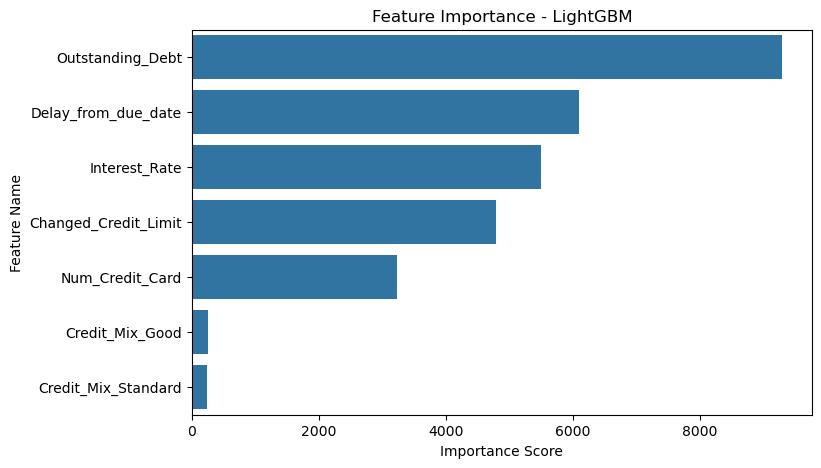

In [81]:
# Plot the top 10 features
plt.figure(figsize=(8, 5))
sns.barplot(x="Importance", y="Feature", data=feat_importance_df[:10])  # Top 10 important features
plt.title("Feature Importance - LightGBM")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.show()

#### As you can see, our Random Forrest model is still performing the best when it comes to maximizing accuracy and minimizing the number of false positives of good class as shown by the confusion matrices. Therefore, Random Forest will be our final model

#### Let's try stacking our top three models with their tuned hyperparameters

In [101]:
# Define base models with their best hyperparameters
base_models = [
    ('random_forest', RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, min_samples_leaf=1, random_state=42)),
    ('xgboost', XGBClassifier(n_estimators=200, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, random_state=42)),
    ('lightgbm', LGBMClassifier(n_estimators=200, learning_rate=0.1, num_leaves=50, subsample=0.8, max_depth=-1, random_state=42))
]

In [102]:
# Define meta-model (Logistic Regression as final classifier)
meta_model = LogisticRegression()

In [103]:
# Create stacking classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5, stack_method='auto', n_jobs=-1)

In [104]:
# Train the stacking model
stacking_clf.fit(X_train_selected, y_train)

StackingClassifier(cv=5,
                   estimators=[('random_forest',
                                RandomForestClassifier(max_depth=20,
                                                       min_samples_split=5,
                                                       n_estimators=200,
                                                       random_state=42)),
                               ('xgboost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=1.0, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_me...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=200, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...)),
                               ('lightgbm',
                                LGBMClassifier(n_estimators=200, num_leaves=50,
                                               random_state=42,
                                               subsample=0.8))],
                   final_estimator=LogisticRegression(), n_jobs=-1)

In [105]:
# Predict on test set
y_pred_stacking = stacking_clf.predict(X_test_selected)

In [106]:
# Evaluate performance
accuracy = accuracy_score(y_test, y_pred_stacking)
print(f"Stacking Classifier Accuracy: {accuracy:.4f}")

Stacking Classifier Accuracy: 0.7841


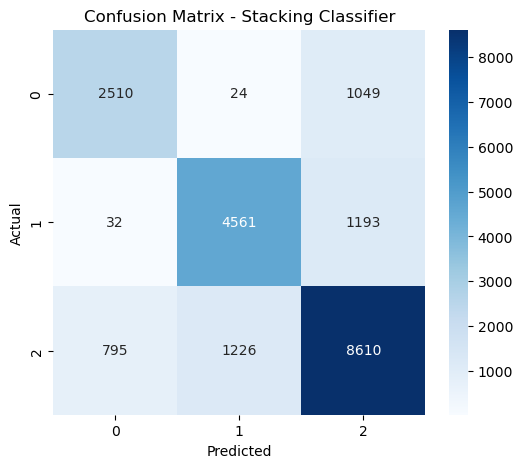

In [107]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_stacking)


# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=stacking_clf.classes_, yticklabels=stacking_clf.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Stacking Classifier")
plt.show()

#### As we can see, the after stacking, our accuracy got reduced, and our false positives for good class also increased. So we will stick with our Random Forest Model with tuned hyperparameters